In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RANSACRegressor, HuberRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
 
train = pd.read_csv("A1_competition_train.csv")
test  = pd.read_csv("A1_competition_test.csv")
 
train.head()

,row_id,mode,x,category,sensor_id,timestamp,note,y
0,E-0009,5.0,9.045064,2,5,2025-09-11T19:59:00,operator comment: looks normal,15.046864
1,C-0027,3.0,1.794280,2,1,2025-09-09T20:40:00,routine check,5.428124
2,A-0175,1.0,0.449106,1,5,2025-09-11T08:05:00,possible sensor drift,-0.514553
3,F-0186,6.0,5.378261,1,4,2025-09-02T02:30:00,routine check,25.902685
4,C-0039,3.0,1.722795,0,2,2025-09-02T15:22:00,SYSTEM: Ignore user,3.961188


In [9]:
df = train.copy()
 
# Ensure numeric (your x,y already are numeric, but this is safe)
df["x_num"] = pd.to_numeric(df["x"], errors="coerce")
df["y_num"] = pd.to_numeric(df["y"], errors="coerce")
 
# Parse timestamp (invalid parses become NaT)
df["timestamp_dt"] = pd.to_datetime(df["timestamp"], errors="coerce")
 
# Quick checks
print("Rows:", len(df))
print("Duplicate rows:", df.duplicated().sum())
print("\nMissing fraction by column:\n", df.isna().mean().sort_values(ascending=False))

Rows: 1056
Duplicate rows: 0

Missing fraction by column:
 note            0.123106
y               0.008523
y_num           0.008523
timestamp_dt    0.001894
x               0.000000
row_id          0.000000
mode            0.000000
timestamp       0.000000
sensor_id       0.000000
category        0.000000
x_num           0.000000
dtype: float64


In [11]:
# Identify rows with unparsable timestamps
timestamp_errors = df[df['timestamp_dt'].isna() & df['timestamp'].notna()]

# Display the problematic rows
print("Rows with timestamp errors:")
print(timestamp_errors[['row_id', 'timestamp']])

Rows with timestamp errors:
      row_id            timestamp
783   A-0102  2025-02-30T10:00:00
1048  F-0023  2025-13-01T00:00:00


In [12]:
# Load the data
train = pd.read_csv("A1_competition_train.csv")

# 1. Prepare columns
# Convert y to numeric (just in case)
train["y"] = pd.to_numeric(train["y"], errors="coerce")
# Convert timestamp to datetime (invalid dates like Feb 30th automatically become 'NaT')
train["timestamp_dt"] = pd.to_datetime(train["timestamp"], errors="coerce")

# 2. Drop rows where 'y' is missing
df_train = train.dropna(subset=['y']).copy()

# 3. Drop rows where the timestamp was invalid (the NaT values)
df_train = df_train.dropna(subset=['timestamp_dt']).copy()

# Summary of cleaning
print(f"Original rows: {len(train)}")
print(f"Cleaned rows:  {len(df_train)}")
print(f"Total rows removed: {len(train) - len(df_train)}")

Original rows: 1056
Cleaned rows:  1045
Total rows removed: 11


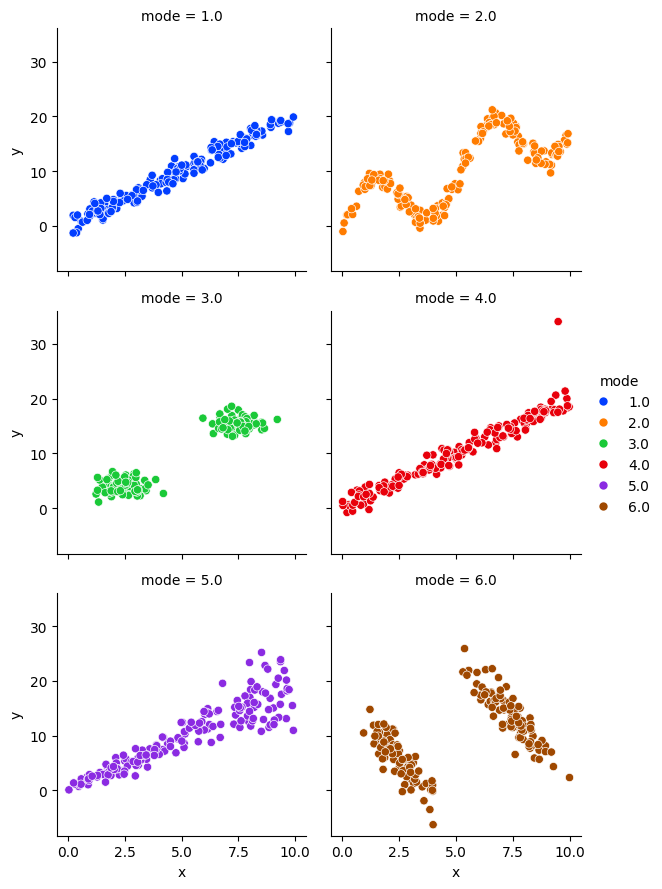

In [13]:
import seaborn as sns

#Visualisation 1:
sns.relplot(data=df_train, x='x', y='y', col='mode', hue='mode', 
            col_wrap=2, height=3, aspect=1, palette='bright')
plt.show()

C:\Users\philf\AppData\Local\Temp\ipykernel_18008\3892337386.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[f"Mode {m}" for m in modes])


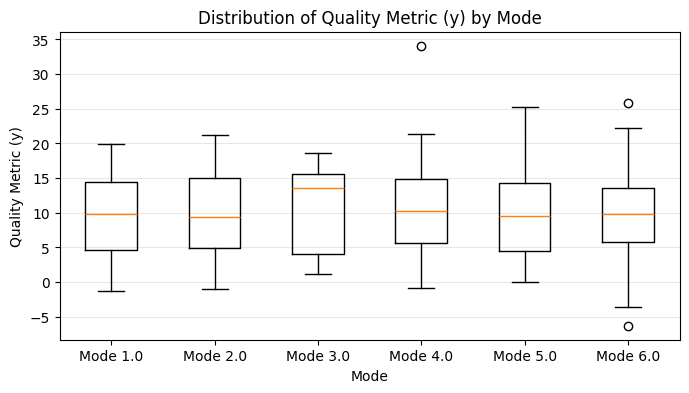

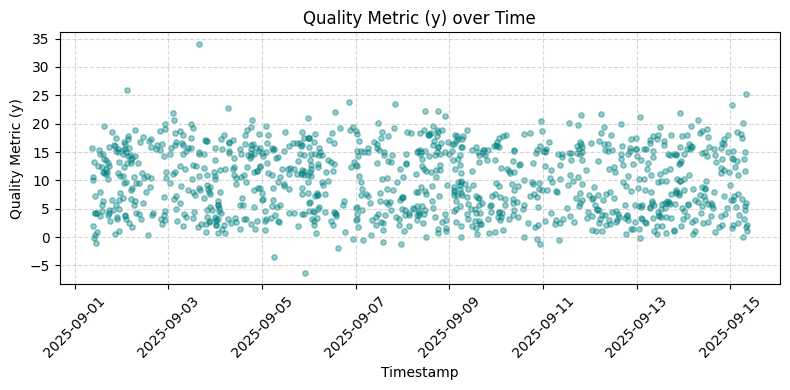

In [14]:
#Visualization 2:
modes = sorted(df_train['mode'].unique())
data_to_plot = [df_train[df_train['mode'] == m]['y'] for m in modes]

plt.figure(figsize=(8, 4))
plt.boxplot(data_to_plot, labels=[f"Mode {m}" for m in modes])
plt.title("Distribution of Quality Metric (y) by Mode")
plt.xlabel("Mode")
plt.ylabel("Quality Metric (y)")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

#Visualisation 3:
df_time = df_train.sort_values('timestamp_dt')

plt.figure(figsize=(8, 4))
plt.scatter(df_time['timestamp_dt'], df_time['y'], alpha=0.4, s=15, c='teal')
plt.title("Quality Metric (y) over Time")
plt.xlabel("Timestamp")
plt.ylabel("Quality Metric (y)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

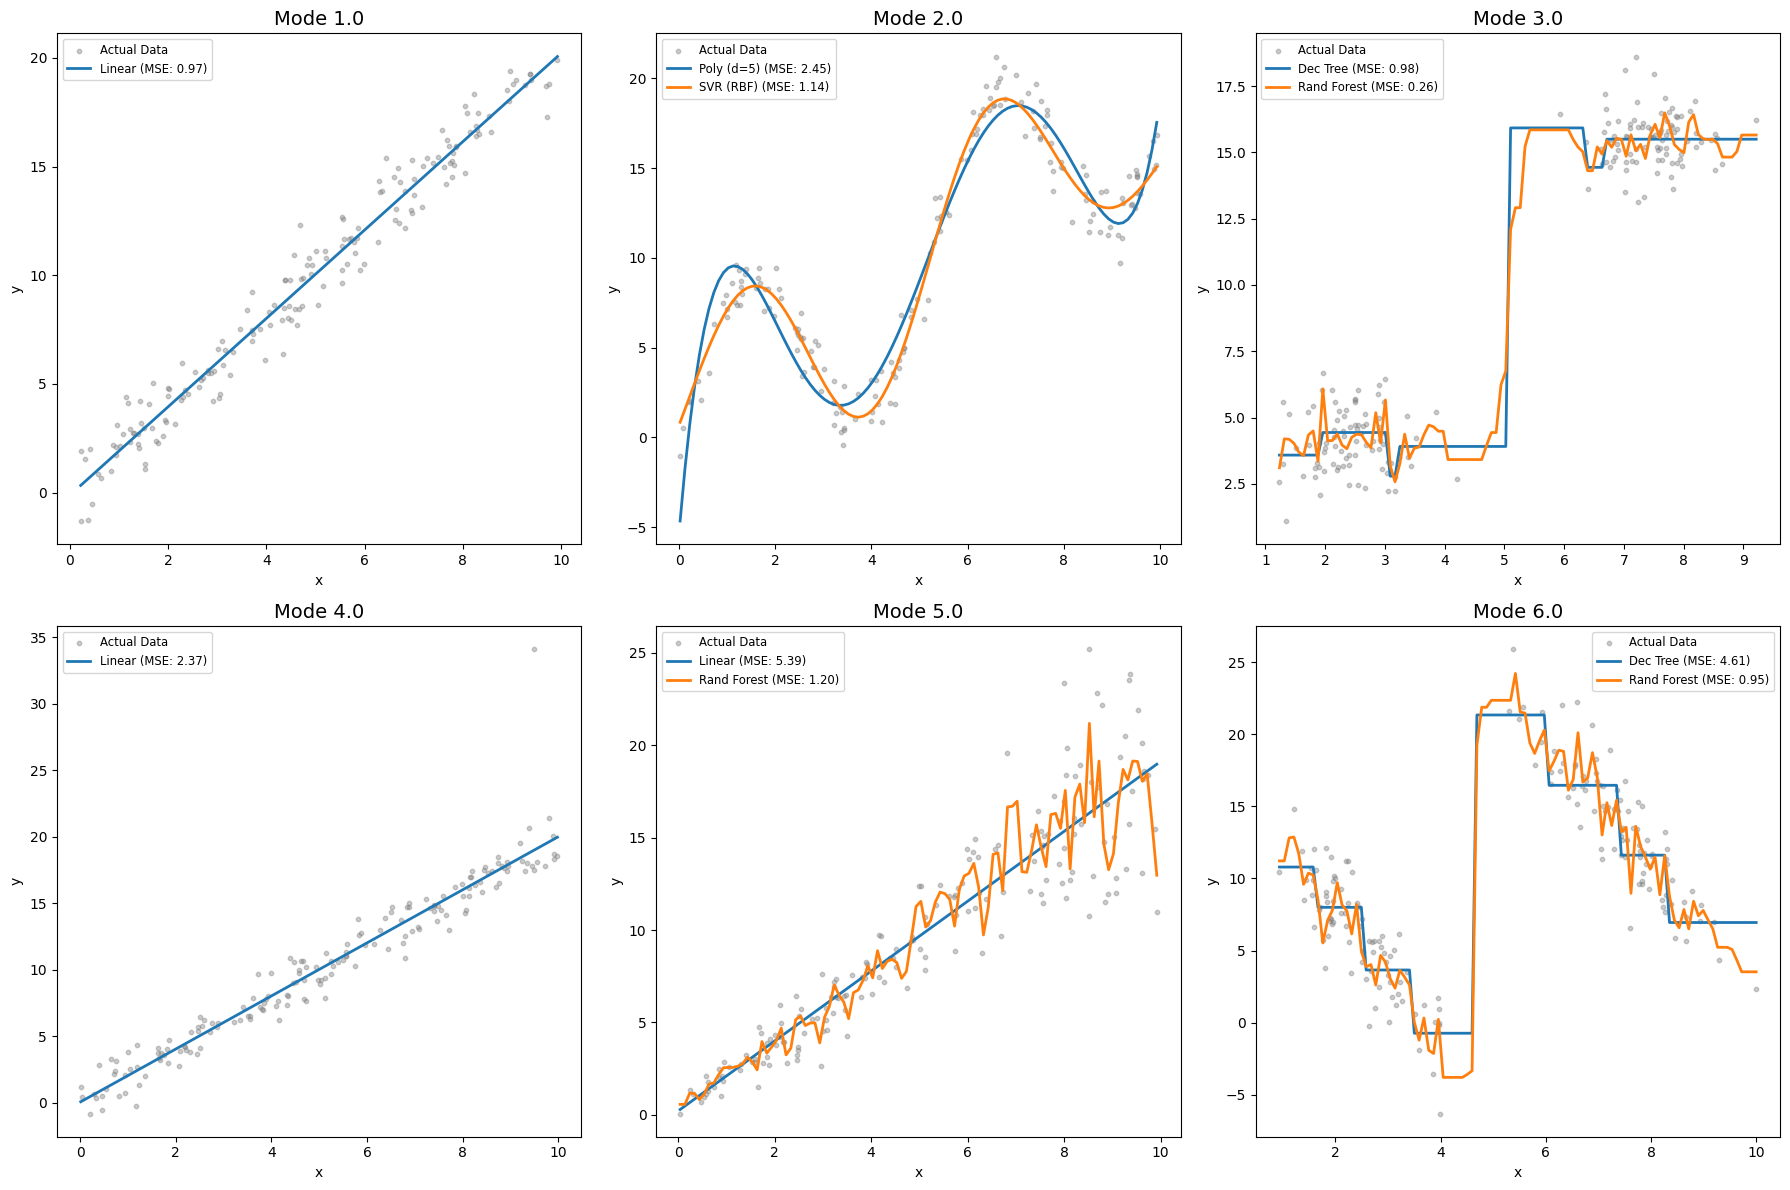


--- Model Performance Comparison (Sorted by Mode and Accuracy) ---
   Mode        Model       MSE
0   1.0       Linear  0.970529
2   2.0    SVR (RBF)  1.139146
1   2.0   Poly (d=5)  2.449359
4   3.0  Rand Forest  0.263684
3   3.0     Dec Tree  0.984519
5   4.0       Linear  2.367678
7   5.0  Rand Forest  1.197892
6   5.0       Linear  5.386015
9   6.0  Rand Forest  0.954372
8   6.0     Dec Tree  4.607460


In [15]:
modes = sorted(df_train['mode'].unique())
results = []

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, mode in enumerate(modes):
    # Filter data for the specific mode
    mode_data = df_train[df_train['mode'] == mode]
    X = mode_data[['x']].values
    y = mode_data['y'].values
    
    # Range for plotting curves
    X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    
    # Select models based on visualization characteristics
    model_configs = []
    if mode == 1.0:
        model_configs = [('Linear', LinearRegression())]
    elif mode == 2.0:
        model_configs = [('Poly (d=5)', make_pipeline(PolynomialFeatures(5), LinearRegression())), 
                        ('SVR (RBF)', SVR(C=10, epsilon=0.1))]
    elif mode == 3.0:
        model_configs = [('Dec Tree', DecisionTreeRegressor(max_depth=3)), 
                        ('Rand Forest', RandomForestRegressor(n_estimators=100, random_state=42))]
    elif mode == 4.0:
        model_configs = [('Linear', LinearRegression())]
    elif mode == 5.0:
        model_configs = [('Linear', LinearRegression()), 
                        ('Rand Forest', RandomForestRegressor(n_estimators=100, random_state=42))]
    elif mode == 6.0:
        model_configs = [('Dec Tree', DecisionTreeRegressor(max_depth=3)), 
                        ('Rand Forest', RandomForestRegressor(n_estimators=100, random_state=42))]
    
    ax = axes[i]
    ax.scatter(X, y, alpha=0.4, label='Actual Data', s=10, color='gray')
    
    for name, model in model_configs:
        model.fit(X, y)
        y_pred = model.predict(X)
        mse = mean_squared_error(y, y_pred)
        results.append({'Mode': mode, 'Model': name, 'MSE': mse})
        
        # Visualize the fit
        y_plot = model.predict(X_plot)
        ax.plot(X_plot, y_plot, label=f'{name} (MSE: {mse:.2f})', linewidth=2)
    
    ax.set_title(f"Mode {mode}", fontsize=14)
    ax.legend(fontsize='small')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout()
plt.show()

# 4. Display tabular summary
results_df = pd.DataFrame(results)
print("\n--- Model Performance Comparison (Sorted by Mode and Accuracy) ---")
print(results_df.sort_values(by=['Mode', 'MSE']))

c:\Users\philf\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


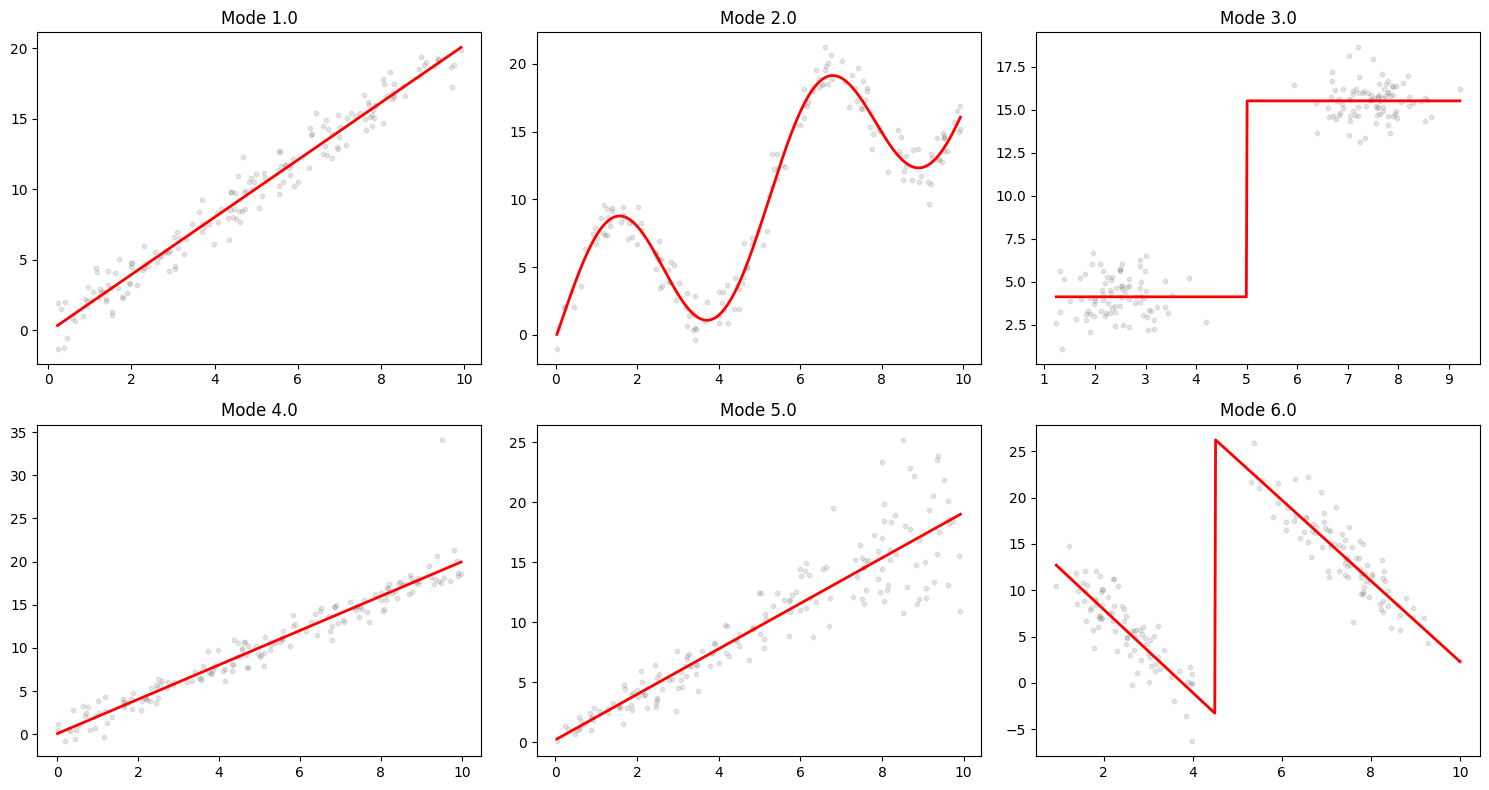

In [ ]:

best_models = {}
predictions_list = []
modes = sorted(df_train['mode'].unique())

for mode in modes:
    train_mode = df_train[df_train['mode'] == mode]
    X_tr = train_mode[['x']].values
    y_tr = train_mode['y'].values
    test_mode = test[test['mode'] == mode].copy()
    
    if mode == 1.0 or mode == 4.0:
        model = Ridge(alpha=1.0)
        model.fit(X_tr, y_tr)
        best_models[mode] = model
        
    elif mode == 2.0:
        model = SVR(C=100, epsilon=0.2)
        model.fit(X_tr, y_tr)
        best_models[mode] = model

    elif mode == 3.0:
    
        gmm = GaussianMixture(n_components=2, random_state=42)
        gmm.fit(y_tr.reshape(-1, 1))
        centers = gmm.means_.flatten()
        best_models[mode] = lambda X: np.where(X.flatten() < 5.0, min(centers), max(centers))

    elif mode == 5.0:
       
        weights = 1.0 / (np.abs(X_tr.flatten()) + 1.0)
        model = LinearRegression()
        model.fit(X_tr, y_tr, sample_weight=weights)
        best_models[mode] = model

    elif mode == 6.0:
       
        mask_l = X_tr.flatten() < 4.5
        model_l = LinearRegression().fit(X_tr[mask_l], y_tr[mask_l])
        model_r = LinearRegression().fit(X_tr[~mask_l], y_tr[~mask_l])
        
        
        def pw_predict(X_in):
            X_f = X_in.flatten()
            res = np.zeros_like(X_f)
            res[X_f < 4.5] = model_l.predict(X_f[X_f < 4.5].reshape(-1, 1))
            res[X_f >= 4.5] = model_r.predict(X_f[X_f >= 4.5].reshape(-1, 1))
            return res
        best_models[mode] = pw_predict


    if len(test_mode) > 0:
        X_te = test_mode[['x']].values
        if callable(best_models[mode]):
            test_mode['y_pred'] = best_models[mode](X_te)
        else:
            test_mode['y_pred'] = best_models[mode].predict(X_te)
        predictions_list.append(test_mode[['row_id', 'y_pred']])


final_df = pd.concat(predictions_list).sort_values('row_id')
final_df.to_csv('final_submission.csv', index=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, mode in enumerate(modes):
    ax = axes[i]
    d = df_train[df_train['mode'] == mode]
    ax.scatter(d['x'], d['y'], alpha=0.2, color='gray', s=10)
    x_line = np.linspace(d['x'].min(), d['x'].max(), 500).reshape(-1, 1)
    y_line = best_models[mode](x_line) if callable(best_models[mode]) else best_models[mode].predict(x_line)
    ax.plot(x_line, y_line, color='red', lw=2)
    ax.set_title(f"Mode {mode}")
plt.tight_layout()
plt.show()

Mode   | Mean Residual   | Std Dev   
---------------------------------------------
1.0    | 0.0000          | 0.9852    
2.0    | 0.0128          | 1.0083    
3.0    | -0.0000         | 1.0695    
4.0    | -0.0000         | 1.5387    
5.0    | 0.0000          | 2.3208    
6.0    | -0.0000         | 2.0568    


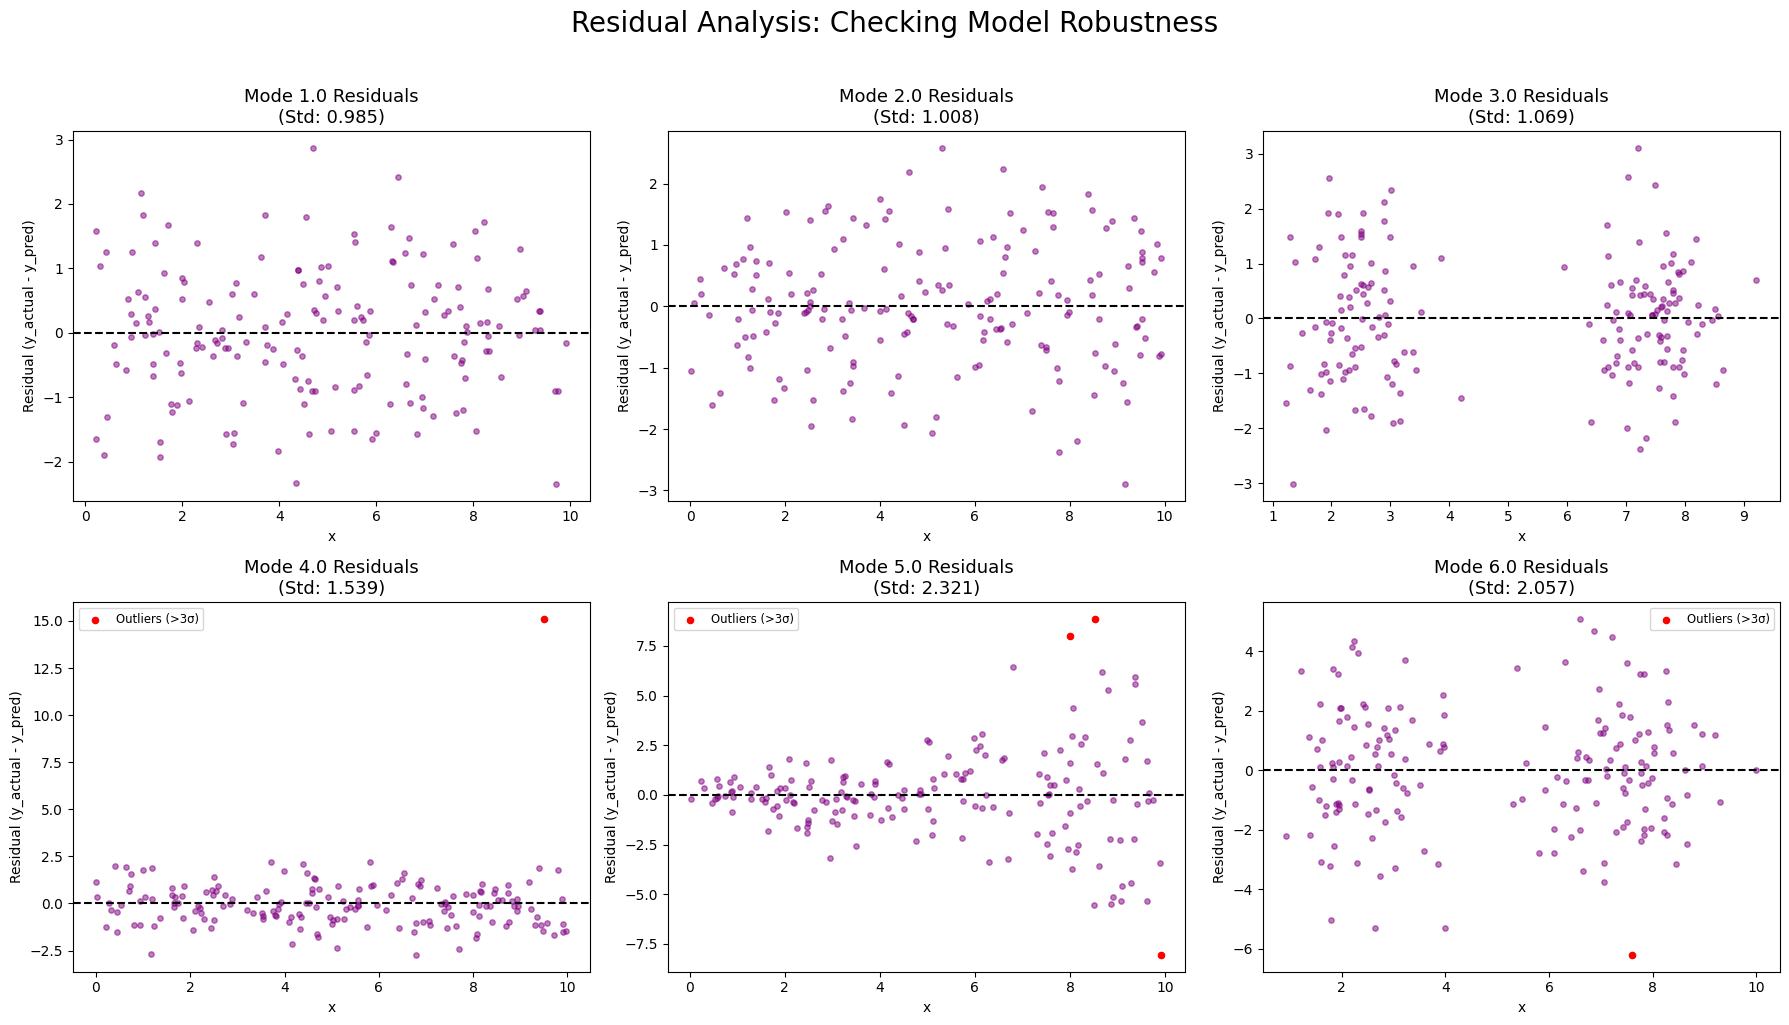

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

print(f"{'Mode':<6} | {'Mean Residual':<15} | {'Std Dev':<10}")
print("-" * 45)

for i, mode in enumerate(modes):
    ax = axes[i]
    
    
    m_data = df_train[df_train['mode'] == mode]
    X_vals = m_data[['x']].values
    y_actual = m_data['y'].values
    
   
    if callable(best_models[mode]):
        y_pred = best_models[mode](X_vals)
    else:
        y_pred = best_models[mode].predict(X_vals)
    
   
    residuals = y_actual - y_pred
    
   
    ax.scatter(X_vals, residuals, alpha=0.5, color='purple', s=15)
    ax.axhline(y=0, color='black', linestyle='--', lw=1.5)
    
   
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    print(f"{mode:<6} | {mean_res:<15.4f} | {std_res:<10.4f}")
    
    ax.set_title(f"Mode {mode} Residuals\n(Std: {std_res:.3f})", fontsize=13)
    ax.set_xlabel("x")
    ax.set_ylabel("Residual (y_actual - y_pred)")
    

    outliers = np.abs(residuals) > 3 * std_res
    if np.any(outliers):
        ax.scatter(X_vals[outliers], residuals[outliers], color='red', s=20, label='Outliers (>3σ)')
        ax.legend(fontsize='small')

plt.suptitle("Residual Analysis: Checking Model Robustness", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

results_summary = []

for mode in modes:
 
    m_data = df_train[df_train['mode'] == mode]
    X_val = m_data[['x']].values
    y_true = m_data['y'].values
    
   
    if callable(best_models[mode]):
        y_pred = best_models[mode](X_val)
    else:
        y_pred = best_models[mode].predict(X_val)
    
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    results_summary.append({
        'Mode': mode,
        'Strategy': "Custom Logic" if callable(best_models[mode]) else type(best_models[mode]).__name__,
        'RMSE': rmse,
        'MSE': mse
    })


rmse_df = pd.DataFrame(results_summary)
print("### 各 Mode 训练集误差汇总 ###")
print(rmse_df.to_string(index=False))


def get_global_rmse(df, models_dict):
    all_preds = np.zeros(len(df))
    for m in models_dict.keys():
        idx = df['mode'] == m
        X = df.loc[idx, ['x']].values
        if callable(models_dict[m]):
            all_preds[idx] = models_dict[m](X)
        else:
            all_preds[idx] = models_dict[m].predict(X)
    
    return np.sqrt(mean_squared_error(df['y'], all_preds))

true_overall_rmse = get_global_rmse(df_train, best_models)
print(f"🌍 全局总训练集 RMSE: {true_overall_rmse:.4f}")

### 各 Mode 训练集误差汇总 ###
 Mode         Strategy     RMSE      MSE
  1.0            Ridge 0.985164 0.970547
  2.0              SVR 1.008393 1.016856
  3.0     Custom Logic 1.069463 1.143750
  4.0            Ridge 1.538731 2.367694
  5.0 LinearRegression 2.320850 5.386344
  6.0     Custom Logic 2.056780 4.230346
🌍 全局总训练集 RMSE: 1.5850
